In [1]:
import os
import shutil
from time import sleep
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np

from batchflow.models.tf import ScalableModel

from batchflow import Pipeline, B, V, C, D
from batchflow.opensets import MNIST
from batchflow.research import Option, Research, Results

%env CUDA_VISIBLE_DEVICES='6,7'

env: CUDA_VISIBLE_DEVICES='6,7'


In [2]:
dataset = MNIST()

BATCH_SIZE = 64

In [3]:
model_config = {
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'initial_block/inputs': 'images',
    
    'initial_block': dict(layout='cna cna', kernel_size=3, filters=8),
    
    'common/width_factor': C('width_factor'),
    'common/depth_factor': C('depth_factor'),
    
    'loss': 'crossentropy',
    'optimizer': 'Adam', 
}

train_ppl = (dataset.train.p
                  .init_variable('loss') 
                  .init_model('dynamic', ScalableModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss',
                               images=B('images'), labels=B('labels'), 
                               save_to=V('loss'))
             .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

test_ppl = (dataset.test.p
                 .import_model('mnist_model', C('import_from'))
                 .init_variable('loss')
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .to_array()
                 .predict_model('mnist_model', fetches=['loss', 'predictions'],
                                images=B('images'), labels=B('labels'), 
                                save_to=[V('loss'), V('predictions')])
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='logits', axis=-1, save_to=V('metrics'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))


In [4]:
op1 = Option('width_factor', [1, 2])
op2 = Option('depth_factor', [1, 2])
grid = op1 * op2

list(grid.gen_configs())

[ConfigAlias({'depth_factor': '1', 'width_factor': '1'}),
 ConfigAlias({'depth_factor': '2', 'width_factor': '1'}),
 ConfigAlias({'depth_factor': '1', 'width_factor': '2'}),
 ConfigAlias({'depth_factor': '2', 'width_factor': '2'})]

In [5]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train')
            .add_pipeline(test_ppl, variables='loss', name='test', execute=10,
                          run=True, import_from='train')
            .get_metrics(pipeline='test', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=10)
            .add_grid(grid))

In [6]:
!rm -r scalable_research

rm: cannot remove 'scalable_research': No such file or directory


In [7]:
NUM_REPEATS = 3
NUM_ITERS = 200
research_name = 'scalable_research'

research.run(n_reps=NUM_REPEATS, n_iters=NUM_ITERS, name=research_name, bar=True, workers=2, gpu=[6,7])


Research scalable_research is starting...


  0%|          | 0/2400 [00:00<?, ?it/s]

Distributor has 12 jobs with 200 iterations. Totally: 2400


100%|██████████| 2400/2400 [05:41<00:00,  7.03it/s]


In [8]:
res = research.load_results(use_alias=True)
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2880 entries, 0 to 19
Data columns (total 6 columns):
accuracy      240 non-null float64
config        2880 non-null object
iteration     2880 non-null int64
loss          2640 non-null float64
name          2880 non-null object
repetition    2880 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 157.5+ KB


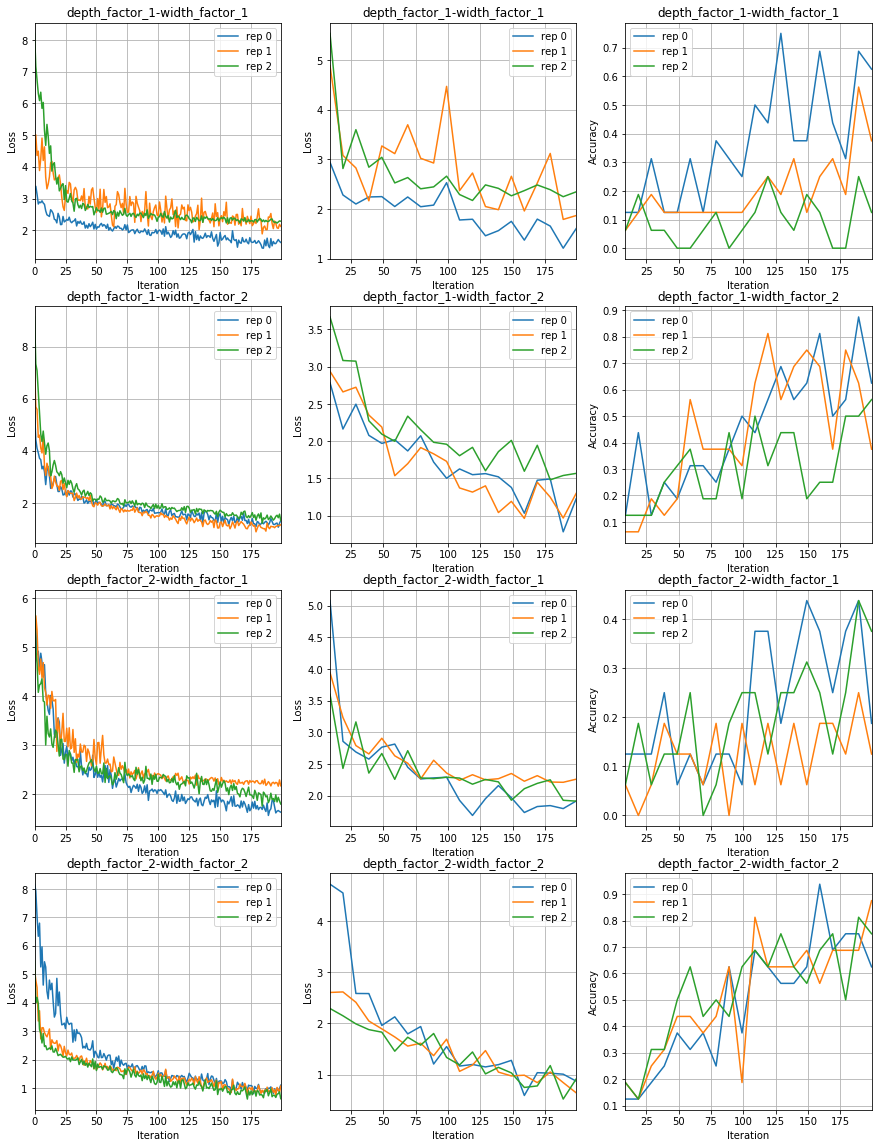

In [9]:
from batchflow.utils import plot_results_by_config

plot_results_by_config(res, (('train', 'loss'), ('test', 'loss'), ('test_metrics', 'accuracy')))